In [61]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

import planecrashinfo_light as pci

from sklearn.cluster import KMeans
from sklearn.externals import joblib

from gensim import corpora, models, utils
from gensim.models import TfidfModel, LsiModel

import nltk
from nltk.corpus import stopwords

%matplotlib inline

# Raw data

In [2]:
df = pd.read_csv('data/data.csv')

# Clean(er) Data

In [3]:
df = pci.clean_database(df)
df.head()

,Time,Location,Operator,Route,AC_Type,Aboard,Fatalities,Ground,Summary,Origin,Destination,Fatalities_total,Location_Country,Accident_type
Date,,,,,,,,,,,,,,
1921-02-03,NaN,"Mendotta, Minnesota",US Aerial Mail Service,NaN,De Havilland DH-4,1 (passengers:0 crew:1),1 (passengers:0 crew:1),0.0,Shortly after takeoff from Minneapolis-World C...,NaN,NaN,1.0,USA,0
1921-02-09,NaN,"La Crosse, Wisconsin",US Aerial Mail Service,NaN,Junkers F-13,3 (passengers:0 crew:3),3 (passengers:0 crew:3),0.0,Crashed for unknown reasons. Both pilots and t...,NaN,NaN,3.0,USA,0
1921-02-15,NaN,Gibraltar,Aeropostale,NaN,Breguet 14,2 (passengers:0 crew:2),2 (passengers:0 crew:2),0.0,The mail fligh encountered poor weather condit...,NaN,NaN,2.0,Gibraltar,0
1921-02-22,NaN,"Elko, Nevada",US Aerial Mail Service,NaN,De Havilland DH-4,1 (passengers:0 crew:1),1 (passengers:0 crew:1),0.0,"Shortly after taking off, the aircraft stalled...",NaN,NaN,1.0,USA,0
1921-04-06,NaN,"Point Cook, Australia",Military - Royal Australian Air Force,NaN,Avro 504,2 (passengers:0 crew:0),2 (passengers:0 crew:0),0.0,"Shortly after taking off on a training flight,...",NaN,NaN,2.0,Australia,0


In [4]:
print('Total number of the data: {}'.format(df.shape[0]))
print('Number of the not empty summaries: {}'.format(df[df.Summary.isnull()].shape[0]))

Total number of the data: 5686
Number of the not empty summaries: 231


## Let's try to cluster summaries
We'll use Latent Dirichlet allocation (LDA). LDA is a topic model that generates topics based on word frequency from a set of documents. LDA is particularly useful for finding reasonably accurate mixtures of topics within a given document set.

In [5]:
# set data without summary as empty row
df.Summary.fillna('', inplace=True)

In [6]:
splitter = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = nltk.tokenize.TreebankWordTokenizer()
stopset = set(stopwords.words('english'))

In [7]:
def text_to_words(text):   
    tokenized_sentences = []
    sentences = splitter.tokenize(text)
    for sentence in sentences:
        tokens = []
        # remove punctuation and stopwords
        for token in utils.tokenize(sentence, lowercase=True, deacc=True, errors="ignore"):
            if token not in stopset:                
                tokens.append(token)
                
        
        tokenized_sentences.extend(tokens)
        tokenized_sentences.extend([' '.join(bigram) for bigram in nltk.ngrams(tokens, 2)])

    return tokenized_sentences

In [8]:
texts = [text_to_words(text) for text in df.Summary.values]

In [9]:
# create dictionary
dictionary = corpora.Dictionary(texts)

In [10]:
# get tokens that appear too often
popular_tokens = [token for token, frequency in dictionary.dfs.items() if frequency > 680]

for token in popular_tokens:
    print(dictionary.get(token))

aircraft
crashed
engine
crew
approach
flight
runway
failure
pilot
plane


In [11]:
# remove from dictionary the tokens that appear too often
dictionary.filter_tokens(popular_tokens)

In [12]:
# create documents corpus
corpus = [dictionary.doc2bow(text) for text in texts]

#### And next question is how many clusters do we have? So let's reduce number of the dimensions for visualization

In [13]:
tfidf = TfidfModel(corpus, dictionary=dictionary, normalize=True)
corpus_tfidf = tfidf[corpus]

We'll use module for Latent Semantic Analysis (aka Latent Semantic Indexing). It implements fast truncated SVD (Singular Value Decomposition)

In [53]:
np.random.seed(42)

# project to 2 dimensions for visualization
lsi_model = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

In [54]:
# save coordinates
coords = []

for coord in lsi_model[corpus]:
    if len(coord) > 1:
        coords.append((coord[0][1], coord[1][1]))

In [55]:
max_clusters = 10
clusters_num = range(1, max_clusters + 1)
inertias = np.zeros(max_clusters)

In [56]:
for cluster_num in clusters_num:
    kmeans = KMeans(cluster_num, random_state=42).fit(coords)
    # "inertia_" is sum of distances of samples to their closest cluster center
    inertias[cluster_num - 1] = kmeans.inertia_

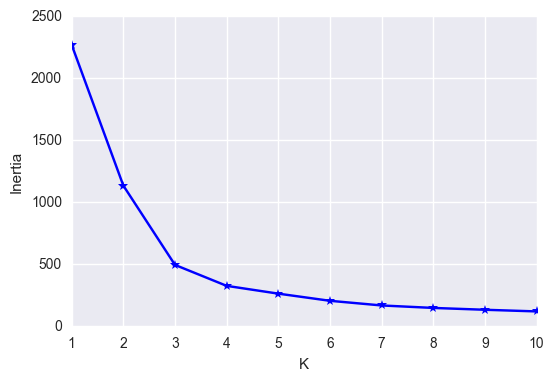

In [57]:
plt.plot(clusters_num, inertias, "b*-")

plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

In [58]:
# let's choose number of the clusters as 6
final_clusters_number = 6

kmeans = KMeans(final_clusters_number, random_state=42).fit(coords)

In [59]:
# distribution per class
Counter(kmeans.labels_)

Counter({0: 1037, 1: 1717, 2: 172, 3: 361, 4: 287, 5: 1881})

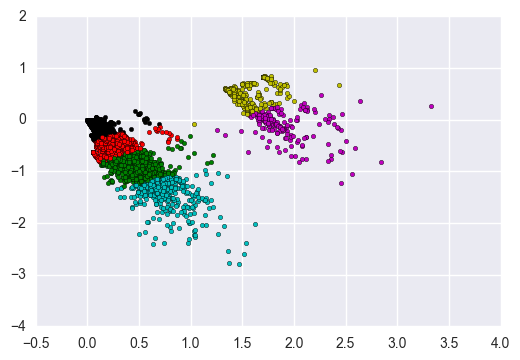

In [60]:
colors = ["g", "r", "m", "c", "y", "k"]

for i in range(len(coords)):
    plt.scatter(coords[i][0], coords[i][1], c=colors[kmeans.labels_[i]], s=10)
    
plt.show()

#### Build LDA model with *num_topics = 7*

In [35]:
np.random.seed(42)

lda = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=final_clusters_number, passes=10)

In [63]:
joblib.dump(lda, 'dumps/lda.pkl')
# lda = joblib.load('dumps/lda.pkl')

['dumps/lda.pkl']

In [36]:
lda.show_topics(final_clusters_number, num_words=10, formatted=False)

[(0,
  [('crashed takeoff', 0.0019627148510899133),
   ('takeoff', 0.0014971220431443486),
   ('mountain poor', 0.00077419310143919261),
   ('poor weather', 0.00075855142118699587),
   ('poor', 0.00071142943923526304),
   ('weather', 0.00066648193278992149),
   ('mountain', 0.00061560579528629545),
   ('ft', 0.0005779274754642822),
   ('landing', 0.00048048182931915913),
   ('crashed burned', 0.00046000037823708631)]),
 (1,
  [('crashed shortly', 0.001054787198294648),
   ('taking', 0.0010225011707444053),
   ('shot', 0.00098489588862058245),
   ('shortly', 0.0009213643819228173),
   ('shortly taking', 0.00082935510809260609),
   ('rebels', 0.00056728356805099754),
   ('takeoff', 0.00048241039372204158),
   ('forces', 0.00047834136067647997),
   ('crashed taking', 0.00046165310804528314),
   ('crashed take', 0.00043040271906388984)]),
 (2,
  [('control', 0.0010502088750443317),
   ('landing', 0.00092092187905057344),
   ('takeoff', 0.0009146352097339918),
   ('taking', 0.00090008645589

In [37]:
# approximate names of the topics

summaries_topics = [
    'takeoff',
    'crashed shortly',
    'landing',
    'weather conditions',
    'in route',
    'crashed in'
]

# Model interpretation

In [47]:
def compute_topic_summary_matrix(model, corpus, summaries_number):
    ts_matrix = pd.DataFrame(
        data=np.zeros((final_clusters_number, summaries_number)), columns=range(summaries_number)
    )
    
    for i in range(summaries_number):
        summary_topics = model.get_document_topics(corpus[i])
        
        for topic, prob in summary_topics:
            ts_matrix[i][topic] += prob
        
    return ts_matrix

([<matplotlib.axis.XTick at 0x7f41259e5cc0>,
 <a list of 6 Text xticklabel objects>)

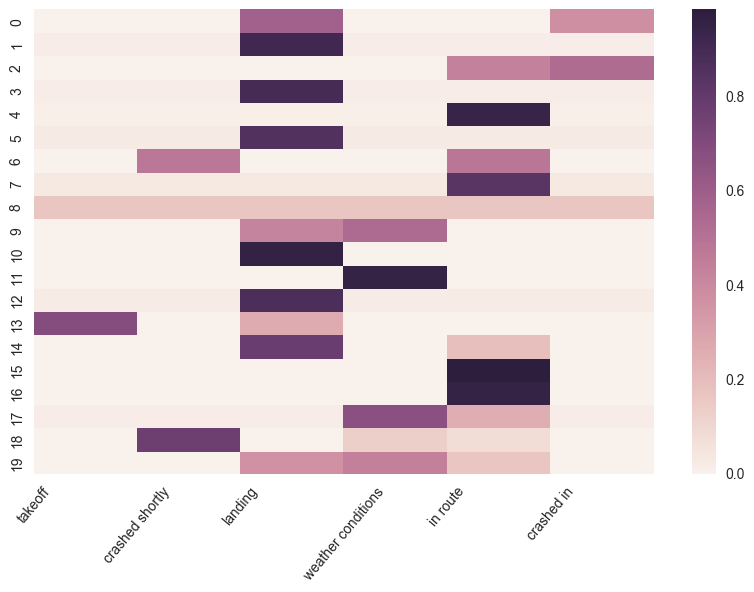

In [50]:
plt.figure(figsize=(10, 6))
seaborn.heatmap(compute_topic_summary_matrix(lda, corpus, 20).transpose())
plt.xticks(range(7), summaries_topics, rotation=50, ha='center')

In [38]:
def get_topic_summary(summary_number):
    summary_topics = lda.get_document_topics(corpus[summary_number])
    summary_topics.sort(key=lambda tup: tup[1], reverse=True)
        
    return summaries_topics[summary_topics[0][0]]

In [39]:
df['Summary_topic'] = 0

for i in range(df.shape[0]):
   df.loc[df.index[i], 'Summary_topic'] = get_topic_summary(i)

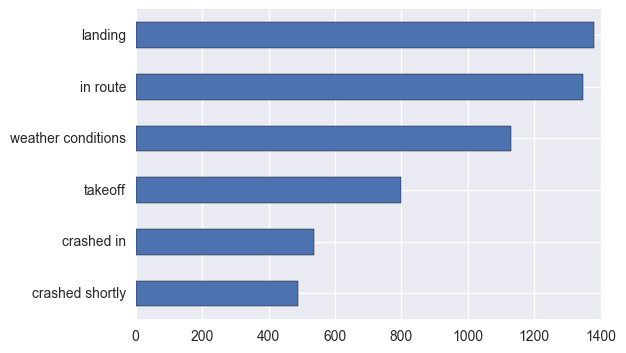

In [45]:
df.Summary_topic.value_counts().sort_values(ascending=True).plot.barh()

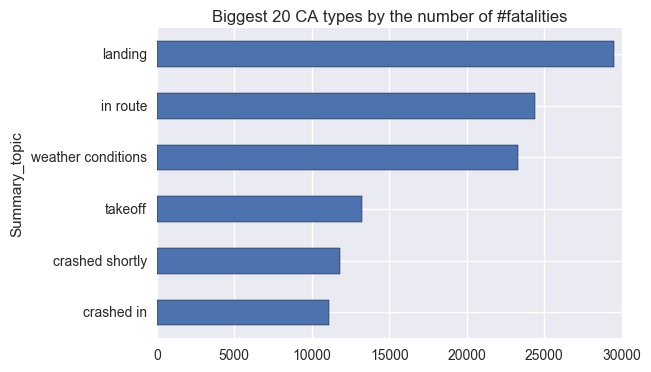

In [42]:
s = df.groupby(by=['Summary_topic']).Fatalities_total.sum().sort_values(ascending=True, na_position='first')[-20:]
s.plot.barh(title='Biggest 20 CA types by the number of #fatalities')

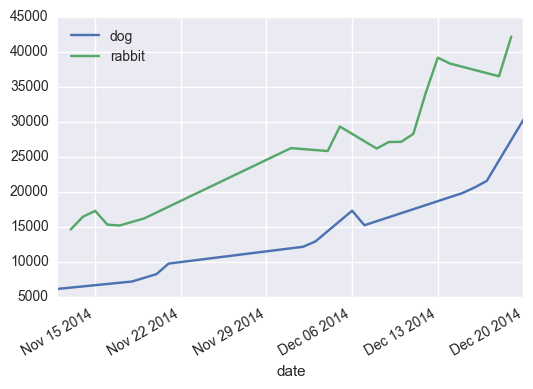

In [98]:
from pandas import Timestamp

df = pd.DataFrame({'animal': ['dog', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'dog', 'rabbit', 'dog', 'dog', 'rabbit', 'dog', 'dog', 'rabbit', 'rabbit', 'dog', 'dog', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'dog', 'dog', 'dog', 'rabbit', 'rabbit', 'dog'], 'count': [6136, 14620, 16437, 17273, 15302, 15180, 7177, 16193, 8226, 9741, 26237, 12146, 12910, 25820, 29323, 17294, 15219, 26174, 27112, 27131, 28268, 34059, 39162, 38314, 19807, 20606, 21552, 36499, 42163, 30301], 'date': [Timestamp('2014-11-12 00:00:00'), Timestamp('2014-11-13 00:00:00'), Timestamp('2014-11-14 00:00:00'), Timestamp('2014-11-15 00:00:00'), Timestamp('2014-11-16 00:00:00'), Timestamp('2014-11-17 00:00:00'), Timestamp('2014-11-18 00:00:00'), Timestamp('2014-11-19 00:00:00'), Timestamp('2014-11-20 00:00:00'), Timestamp('2014-11-21 00:00:00'), Timestamp('2014-12-01 00:00:00'), Timestamp('2014-12-02 00:00:00'), Timestamp('2014-12-03 00:00:00'), Timestamp('2014-12-04 00:00:00'), Timestamp('2014-12-05 00:00:00'), Timestamp('2014-12-06 00:00:00'), Timestamp('2014-12-07 00:00:00'), Timestamp('2014-12-08 00:00:00'), Timestamp('2014-12-09 00:00:00'), Timestamp('2014-12-10 00:00:00'), Timestamp('2014-12-11 00:00:00'), Timestamp('2014-12-12 00:00:00'), Timestamp('2014-12-13 00:00:00'), Timestamp('2014-12-14 00:00:00'), Timestamp('2014-12-15 00:00:00'), Timestamp('2014-12-16 00:00:00'), Timestamp('2014-12-17 00:00:00'), Timestamp('2014-12-18 00:00:00'), Timestamp('2014-12-19 00:00:00'), Timestamp('2014-12-20 00:00:00')]})
df = df.set_index('date')

grouped = df.groupby(['animal'])
fig, ax = plt.subplots()
for key, group in grouped:
    group['count'].plot(label=key, ax=ax)

plt.legend(loc='best')

plt.show()